In [1]:
import json
import os
import pickle
import keras
import sqlite3
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from scipy.signal import savgol_filter
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import LSTM, BatchNormalization, Dense, Dropout, Reshape
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1, l2
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

In [2]:



def trim_start_end_nans(df):
    """
    Removes rows at the start and end of a DataFrame that have NaN values in any column.
    """
    # Initialize start_idx and end_idx based on the DataFrame's index type
    if isinstance(df.index, pd.DatetimeIndex):
        start_idx = df.index[0]  # Assume first index is earliest; adjust if necessary
        end_idx = df.index[-1]  # Assume last index is latest; adjust if necessary
    else:
        start_idx = 0
        end_idx = len(df) - 1

    for column in df.columns:
        # Find the first non-NaN index in the current column
        first_valid_index = df[column].first_valid_index()
        if first_valid_index is not None and df.index.get_loc(
            first_valid_index
        ) > df.index.get_loc(start_idx):
            start_idx = first_valid_index

        # Find the last non-NaN index in the current column
        last_valid_index = df[column].last_valid_index()
        if last_valid_index is not None and df.index.get_loc(
            last_valid_index
        ) < df.index.get_loc(end_idx):
            end_idx = last_valid_index

    # Trim the DataFrame
    return df.loc[start_idx:end_idx]




def process_data_for_plot(
    plot_number,
    target_columns,
    continuous_columns,
    start_date="2023-07-20",
    end_date="2023-09-03",
    rolling_windows=[3, 7], 
):
    """
    Process data for a given plot number within a specified date range. This includes:
    * Spike Detection (up and down) for VWC columns
    * Time since last significant precipitation
    * Cumulative precipitation within a time window
    * Rolling window statistics
    * Time Encoding
    """

    # Database connection
    conn = sqlite3.connect("processed_data.db")
    query = "SELECT * FROM data_table"
    df = pd.read_sql_query(query, conn)
    conn.close()

    # Filter by plot_number and date range
    df = df[
        (df["plot_number"] == plot_number)
        & (df["TIMESTAMP"] >= start_date)
        & (df["TIMESTAMP"] <= end_date)
    ]

    # Convert TIMESTAMP to datetime
    df["TIMESTAMP"] = pd.to_datetime(df["TIMESTAMP"])
    df.set_index("TIMESTAMP", inplace=True)

    # Sort by TIMESTAMP 
    df.sort_values(by="TIMESTAMP", inplace=True)

    # Select relevant columns
    df = df[continuous_columns + target_columns]

    # Resample to daily frequency 
    df = df.resample("D").mean()

    # Spike detection for VWC columns
    for col in df.columns:
        if "VWC" in col:
            df[f"{col}_spike_up"] = (df[col] > df[col].shift(1) * 1.15).astype(int)  # 15% increase
            df[f"{col}_spike_down"] = (df[col] < df[col].shift(1) * 0.85).astype(int)  # 15% decrease

    # Time since precipitation (modify thresholds as needed)
    significant_precip_threshold = 0.2  
    max_precip_value = df['precip_irrig'].max()
    df['time_since_last_significant_precip'] = (df['precip_irrig'] > significant_precip_threshold).astype(int)
    df['time_since_last_significant_precip'] = df['time_since_last_significant_precip'].cumsum() - df['time_since_last_significant_precip'].where(df['time_since_last_significant_precip'] == 1).ffill().fillna(0).astype(int)
    
    df['time_since_last_half_max_precip'] = (df['precip_irrig'] > (max_precip_value / 2)).astype(int)
    df['time_since_last_half_max_precip'] = df['time_since_last_half_max_precip'].cumsum() - df['time_since_last_half_max_precip'].where(df['time_since_last_half_max_precip'] == 1).ffill().fillna(0).astype(int)


    # Cumulative precipitation (replace 4 with the desired window)
    df['precip_irrig_cumulative_4day'] = df['precip_irrig'].rolling(4).sum() 

    # Preprocessing 
    df = df.interpolate(method="pchip")

    # Rolling window features
    for window in rolling_windows:
        for col in continuous_columns:
            df[f'{col}_rolling_mean_{window}'] = df[col].rolling(window=window).mean()
            df[f'{col}_rolling_std_{window}'] = df[col].rolling(window=window).std()

    return df

In [3]:
def subtract_mean(df, target_columns, continuous_columns):
    # Subtract mean from each column (append new columns with suffix "_mean_subtracted")
    df_mean_subtracted = df.copy()
    mean_values = {}
    for col in df_mean_subtracted.columns:
        if col in [target_columns + continuous_columns]:
            mean_values[col] = df_mean_subtracted[col].mean()
            df_mean_subtracted[col] = df_mean_subtracted[col] - mean_values[col]
    return df_mean_subtracted, mean_values

def create_derivative_columns(df, target_columns, continuous_columns):
    initial_values = {}
    for col in df.columns:  # Change to apply to all columns
        if col in [target_columns + continuous_columns]:
            initial_values[col] = df[col].iloc[0]
        deriv_col_name = f"{col}_deriv" 
        df[deriv_col_name] = df[col].diff().fillna(0)  # Fill NaN with 0 for initial diff
    return df, initial_values


def transform_and_scale_data(df, target_columns, continuous_columns):
    df_transformed = df.copy()
    df_transformed, mean_values = subtract_mean(df_transformed, target_columns, continuous_columns)  # Change here to apply to all
    df_transformed, initial_values = create_derivative_columns(df_transformed, target_columns, continuous_columns)
    df_transformed["precip_irrig_bool"] = df_transformed["precip_irrig"].apply(
        lambda x: 1 if x > 0 else 0
    )
    
    
    return df_transformed



In [4]:
import numpy as np
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import os
import pickle

def train_and_save_models_with_time_series_validation(X, y, forecast_days, model_save_path):
    # Iterate over forecast days
    for forecast_day in range(1, forecast_days + 1):
        # Shift y forward by forecast_day
        y_shifted = np.roll(y, -forecast_day)
        # The last 'forecast_day' values in y_shifted will be incorrect due to the roll, so we remove them
        X_adjusted = X[:-forecast_day, :]
        y_adjusted = y_shifted[:-forecast_day]

        # Initialize TimeSeriesSplit
        tscv = TimeSeriesSplit(n_splits=5)

        best_model = None
        best_rmse = float("inf")

        # Iterate over each train-test split
        for train_index, val_index in tscv.split(X_adjusted):
            # Split data
            X_train, X_val = X_adjusted[train_index], X_adjusted[val_index]
            y_train, y_val = y_adjusted[train_index], y_adjusted[val_index]

            # Prepare DMatrices
            dtrain = xgb.DMatrix(X_train, label=y_train)
            dval = xgb.DMatrix(X_val, label=y_val)

            # XGBoost parameters
            param = {
                'max_depth': 3,
                'eta': 0.05,
                'objective': 'reg:squarederror',
                'eval_metric': 'rmse',
                'subsample': 0.8,
                'colsample_bytree': 1,
                'lambda': 1,
                'alpha': 0.2,
                'gamma': 0.2
            }

            num_round = 5000  # Number of training iterations

            # Train XGBoost model with early stopping
            bst = xgb.train(
                param,
                dtrain,
                num_round,
                [(dtrain, 'train'), (dval, 'val')],
                early_stopping_rounds=500,
                verbose_eval=False
            )

            # Predict on validation set
            y_val_pred = bst.predict(dval)

            # Calculate RMSE for the current split
            val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
            print(f"Validation RMSE for forecast day {forecast_day}, current split: {val_rmse:.2f}")

            # Update best model if improvement
            if val_rmse < best_rmse:
                best_rmse = val_rmse
                best_model = bst

        # Save the best model for the current forecast day
        best_model_save_path = os.path.join(model_save_path, f"best_model_day_{forecast_day}.pkl")
        os.makedirs(os.path.dirname(best_model_save_path), exist_ok=True)

        with open(best_model_save_path, 'wb') as file:
            pickle.dump(best_model, file)

        print(f"Best model for forecast day {forecast_day} saved to {best_model_save_path}")


c:\Users\bnsoh2\OneDrive - University of Nebraska-Lincoln\Projects\Students\Bryan Nsoh\Indep_study_NsohGuo_2024\ML\models


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 1, current split: 4.31


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 1, current split: 1.49


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 1, current split: 1.01


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 1, current split: 0.79


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 1, current split: 1.28
Best model for forecast day 1 saved to c:\Users\bnsoh2\OneDrive - University of Nebraska-Lincoln\Projects\Students\Bryan Nsoh\Indep_study_NsohGuo_2024\ML\models\best_model_day_1.pkl
Model for day 1 trained and saved for plot 2015


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 1, current split: 4.31


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 1, current split: 1.49


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 1, current split: 1.01


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 1, current split: 0.79


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 1, current split: 1.28
Best model for forecast day 1 saved to c:\Users\bnsoh2\OneDrive - University of Nebraska-Lincoln\Projects\Students\Bryan Nsoh\Indep_study_NsohGuo_2024\ML\models\best_model_day_1.pkl


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 2, current split: 4.15


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 2, current split: 1.39


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 2, current split: 1.53


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 2, current split: 0.80


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 2, current split: 1.22
Best model for forecast day 2 saved to c:\Users\bnsoh2\OneDrive - University of Nebraska-Lincoln\Projects\Students\Bryan Nsoh\Indep_study_NsohGuo_2024\ML\models\best_model_day_2.pkl
Model for day 2 trained and saved for plot 2015


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 1, current split: 4.31


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 1, current split: 1.49


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 1, current split: 1.01


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 1, current split: 0.79


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 1, current split: 1.28
Best model for forecast day 1 saved to c:\Users\bnsoh2\OneDrive - University of Nebraska-Lincoln\Projects\Students\Bryan Nsoh\Indep_study_NsohGuo_2024\ML\models\best_model_day_1.pkl


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 2, current split: 4.15


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 2, current split: 1.39


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 2, current split: 1.53


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 2, current split: 0.80


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 2, current split: 1.22
Best model for forecast day 2 saved to c:\Users\bnsoh2\OneDrive - University of Nebraska-Lincoln\Projects\Students\Bryan Nsoh\Indep_study_NsohGuo_2024\ML\models\best_model_day_2.pkl


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 3, current split: 4.31


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 3, current split: 1.17


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 3, current split: 1.25


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 3, current split: 1.64


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 3, current split: 0.97
Best model for forecast day 3 saved to c:\Users\bnsoh2\OneDrive - University of Nebraska-Lincoln\Projects\Students\Bryan Nsoh\Indep_study_NsohGuo_2024\ML\models\best_model_day_3.pkl
Model for day 3 trained and saved for plot 2015


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 1, current split: 4.31


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 1, current split: 1.49


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 1, current split: 1.01


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 1, current split: 0.79


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 1, current split: 1.28
Best model for forecast day 1 saved to c:\Users\bnsoh2\OneDrive - University of Nebraska-Lincoln\Projects\Students\Bryan Nsoh\Indep_study_NsohGuo_2024\ML\models\best_model_day_1.pkl


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 2, current split: 4.15


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 2, current split: 1.39


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 2, current split: 1.53


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 2, current split: 0.80


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 2, current split: 1.22
Best model for forecast day 2 saved to c:\Users\bnsoh2\OneDrive - University of Nebraska-Lincoln\Projects\Students\Bryan Nsoh\Indep_study_NsohGuo_2024\ML\models\best_model_day_2.pkl


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 3, current split: 4.31


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 3, current split: 1.17


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 3, current split: 1.25


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 3, current split: 1.64


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 3, current split: 0.97
Best model for forecast day 3 saved to c:\Users\bnsoh2\OneDrive - University of Nebraska-Lincoln\Projects\Students\Bryan Nsoh\Indep_study_NsohGuo_2024\ML\models\best_model_day_3.pkl


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 4, current split: 2.19


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 4, current split: 1.11


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 4, current split: 1.03


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 4, current split: 2.15


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 4, current split: 1.75
Best model for forecast day 4 saved to c:\Users\bnsoh2\OneDrive - University of Nebraska-Lincoln\Projects\Students\Bryan Nsoh\Indep_study_NsohGuo_2024\ML\models\best_model_day_4.pkl
Model for day 4 trained and saved for plot 2015
Models path for day 1: c:\Users\bnsoh2\OneDrive - University of Nebraska-Lincoln\Projects\Students\Bryan Nsoh\Indep_study_NsohGuo_2024\ML\models
Models path for day 2: c:\Users\bnsoh2\OneDrive - University of Nebraska-Lincoln\Projects\Students\Bryan Nsoh\Indep_study_NsohGuo_2024\ML\models
Models path for day 3: c:\Users\bnsoh2\OneDrive - University of Nebraska-Lincoln\Projects\Students\Bryan Nsoh\Indep_study_NsohGuo_2024\ML\models
Models path for day 4: c:\Users\bnsoh2\OneDrive - University of Nebraska-Lincoln\Projects\Students\Bryan Nsoh\Indep_study_NsohGuo_2024\ML\models


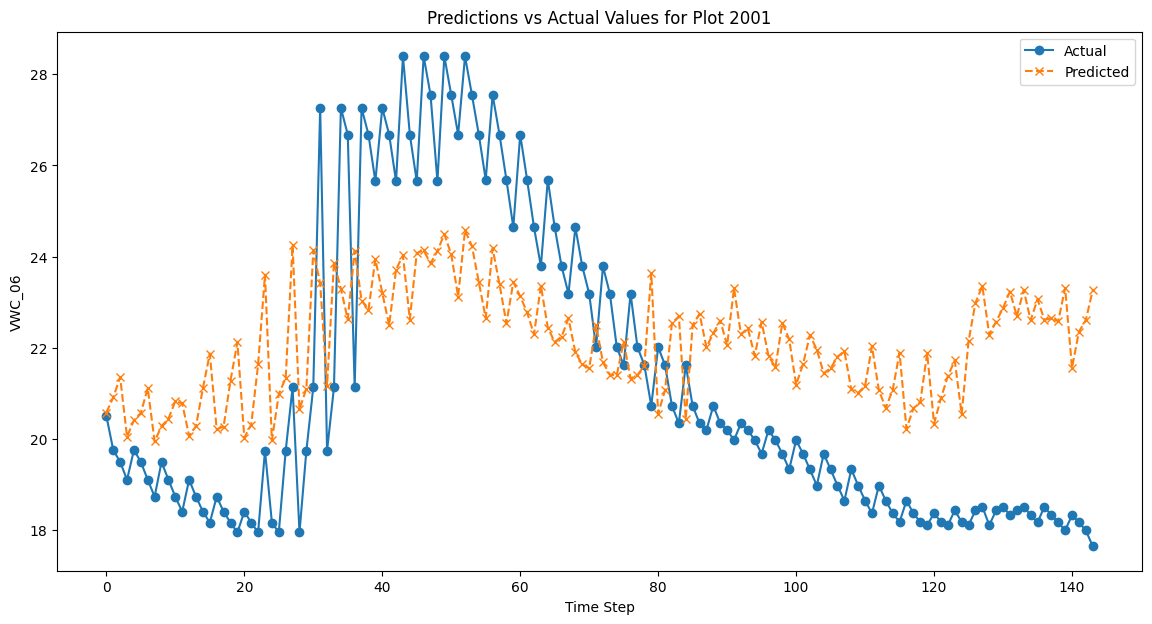

Predictions for plot number 2001:
[[20.58201218 20.91284752 21.35972977 20.05120468]
 [20.41257286 20.57459068 21.11514854 19.94779778]
 [20.28398705 20.44776726 20.83039474 20.78039932]
 [20.06964493 20.28531075 21.11520958 21.87434959]
 [20.21225548 20.27578545 21.28381157 22.12230873]
 [20.03109169 20.31500816 21.63525009 23.60318565]
 [19.97262192 20.98083305 21.34167099 24.24957848]
 [20.65580368 21.10643387 24.13458824 23.41144753]
 [21.17380333 23.86927986 23.30033875 22.62179565]
 [24.13081741 23.03609276 22.83083725 23.9450798 ]
 [23.20825005 22.49503899 23.71460533 24.02886963]
 [22.62068367 24.07892036 24.13535118 23.8532505 ]
 [24.12144089 24.49431801 24.05021858 23.12483788]
 [24.57513237 24.23298454 23.43822098 22.65090561]
 [24.17995644 23.39326859 22.54046631 23.4424305 ]
 [23.13138008 22.77591324 22.29341507 23.36327171]
 [22.44550323 22.1281395  22.24629784 22.64433479]
 [21.89962196 21.63646507 21.55224228 22.49424362]
 [21.67988968 21.41169167 21.4006691  22.1348781

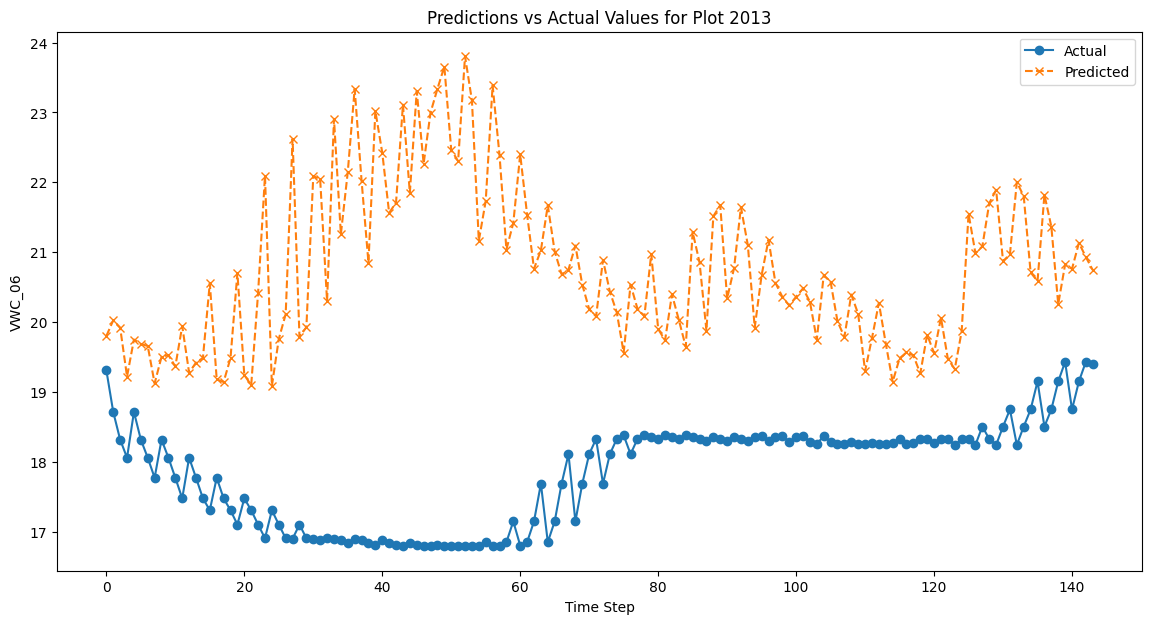

Predictions for plot number 2013:
[[19.8020916  20.02635574 19.92375755 19.22207832]
 [19.75187111 19.68809891 19.65950775 19.12414742]
 [19.50406647 19.52897835 19.36658669 19.94446945]
 [19.27643013 19.42300987 19.48842621 20.55794525]
 [19.18165207 19.14387894 19.48657799 20.7034874 ]
 [19.24526405 19.09909058 20.41793442 22.09658623]
 [19.08853912 19.75938797 20.11496162 22.62229919]
 [19.79066086 19.92788696 22.09114647 22.04115868]
 [20.30282974 22.90855789 21.25867462 22.14727592]
 [23.33760262 22.02646446 20.85193634 23.0211277 ]
 [22.42480659 21.56249046 21.71187019 23.1115303 ]
 [21.85034752 23.3052063  22.26852608 22.99744415]
 [23.338377   23.65624046 22.46583176 22.3037796 ]
 [23.80459785 23.17305756 21.16524124 21.73356628]
 [23.38674164 22.39095879 21.0394783  21.42035294]
 [22.40024185 21.53970528 20.76375771 21.02757263]
 [21.67122841 21.01091576 20.68589973 20.75141907]
 [21.09663582 20.53677368 20.18571091 20.08273125]
 [20.89001083 20.43642044 20.14097404 19.5632743

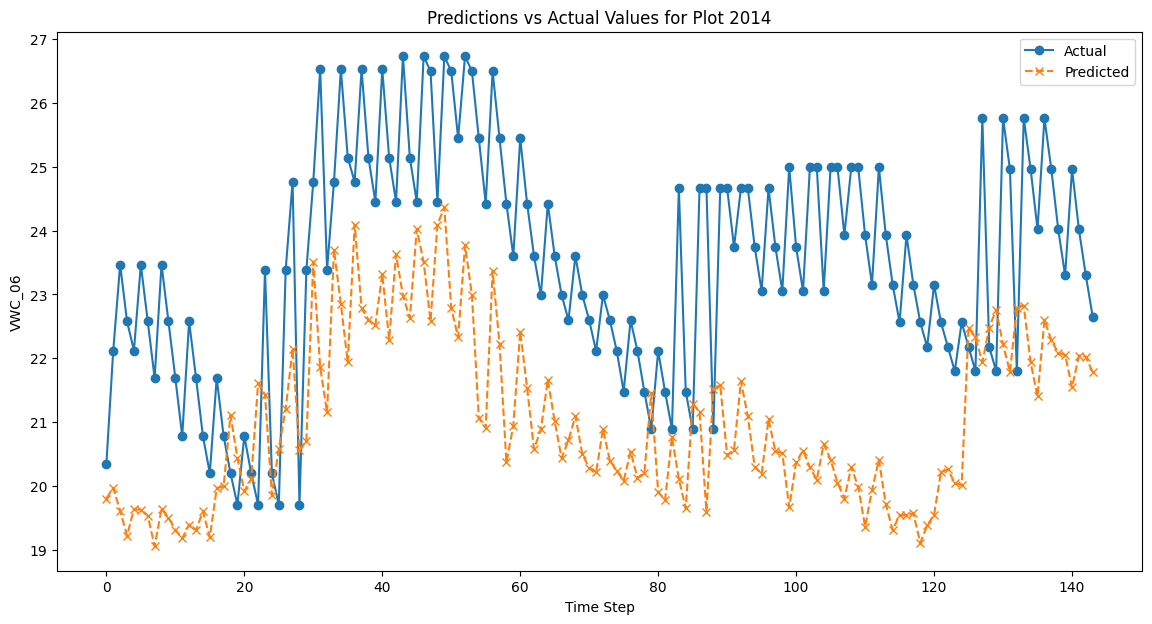

Predictions for plot number 2014:
[[19.8020916  19.96796036 19.61211014 19.22207832]
 [19.63265228 19.6299839  19.53629303 19.05531311]
 [19.64081573 19.5028801  19.31208229 19.17909431]
 [19.39423943 19.3055706  19.60259438 19.1944046 ]
 [19.96157265 19.99523735 21.10853958 20.43888092]
 [19.91715813 20.10789108 21.60664368 21.42960358]
 [19.85868835 20.5757122  21.21013641 22.14742279]
 [20.56081009 20.71013641 23.51511955 21.86106491]
 [21.15113258 23.7006321  22.85206413 21.93587112]
 [24.09503937 22.79049873 22.60041237 22.52430344]
 [23.32253647 22.29436302 23.62925911 22.97981262]
 [22.6302681  24.02220535 23.51224518 22.58462334]
 [24.09543419 24.36513329 22.78852844 22.32817841]
 [23.76920509 22.99581909 21.06524277 20.90834618]
 [23.36425781 22.22909927 20.36819839 20.94421959]
 [22.41889381 21.53970528 20.57792664 20.8872261 ]
 [21.66145706 21.01091576 20.43574524 20.71670914]
 [21.09663582 20.4966011  20.28106689 20.21076012]
 [20.89001083 20.39572334 20.23533249 20.0802402

In [5]:
import pandas as pd
import numpy as np
import os
import sqlite3
import pickle
from xgboost import XGBRegressor
import numpy as np
import matplotlib.pyplot as plt

# Assuming the necessary functions are defined as provided: 
# trim_start_end_nans, process_data_for_plot, subtract_mean, create_derivative_columns, transform_and_scale_data




def prepare_and_train_models(plot_numbers, target_column, continuous_columns, forecast_horizon, model_save_path):
    """
    Prepare data, train models for each forecast horizon, and save the models.
    """
    for plot_number in plot_numbers:
        # Process and transform data
        df = process_data_for_plot(plot_number, [target_column], continuous_columns)
        df = trim_start_end_nans(df)
        df_transformed = transform_and_scale_data(df, [target_column], continuous_columns)

        # Define training data
        X = df_transformed.drop(columns=[target_column]).values
        y = df_transformed[target_column].values

        # Train and save model for each forecast horizon
        for forecast_day in range(1, forecast_horizon + 1):  # Example: 3-day forecast horizon
            train_and_save_models_with_time_series_validation(X, y, forecast_day, model_save_path)
            print(f"Model for day {forecast_day} trained and saved for plot {plot_number}")

def predict_with_model(model_path, X):
    """
    Load a model from a file and make predictions.
    """
    
    with open(model_path, 'rb') as file:
        model = pickle.load(file)
        
    dtest = xgb.DMatrix(X)
    return model.predict(dtest)


def run_inference(models_path, plot_number, target_column, continuous_columns, forecast_horizon):
    # Process and transform data for inference
    df = process_data_for_plot(plot_number, [target_column], continuous_columns)
    df = trim_start_end_nans(df)
    df_transformed = transform_and_scale_data(df, [target_column], continuous_columns)

    X = df_transformed.drop(columns=[target_column]).values
    y_actual = df_transformed[target_column].values

    predictions = np.zeros((len(X) - forecast_horizon + 1, forecast_horizon))

    for day in range(1, forecast_horizon + 1):
        model_path = os.path.join(models_path, f"best_model_day_{day}.pkl")
        print(f"Models path for day {day}: {models_path}")
        pred = predict_with_model(model_path, X[:-(forecast_horizon - day) if (forecast_horizon - day) > 0 else None])
        for i in range(min(len(pred), len(predictions))):
            predictions[i, day - 1] = pred[i]

    # Filter out rows where all values are zero (assuming zero predictions are not expected)
    predictions = predictions[~np.all(predictions == 0, axis=1)]

    # Flatten predictions and actuals to plot on the same curve
    flat_predictions = predictions.flatten()
    # Adjust actuals to match the length of filtered predictions
    adjusted_length = len(flat_predictions) // forecast_horizon
    flat_actuals = np.array([y_actual[i:i+forecast_horizon] for i in range(adjusted_length)]).flatten()

    # Plotting
    plt.figure(figsize=(14, 7))
    plt.plot(flat_actuals, label='Actual', linestyle='-', marker='o')
    plt.plot(flat_predictions, label='Predicted', linestyle='--', marker='x')

    plt.title(f'Predictions vs Actual Values for Plot {plot_number}')
    plt.xlabel('Time Step')
    plt.ylabel(target_column)
    plt.legend()
    plt.show()

    return predictions


# Example usage
plot_numbers = [2015]  # Example plot numbers for training
target_column = "VWC_06"
continuous_columns = [
    "Ta_2m_Avg", "RH_2m_Avg", "Solar_2m_Avg", "WndAveSpd_3m", "Rain_1m_Tot",
    "Dp_2m_Avg", "TaMax_2m", "TaMin_2m", "RHMax_2m", "RHMin_2m",
    "HeatIndex_2m_Avg", "irrigation", "precip_irrig", "canopy_temp","VWC_18", "VWC_30"
]

model_save_path = os.path.join(os.getcwd(), "models") 

print(model_save_path)
forecast_horizon = 4

# Train models
prepare_and_train_models(plot_numbers, target_column, continuous_columns, forecast_horizon, model_save_path)

# Define a list of plot numbers for which you want to run inference
plot_numbers_for_inference = [2001, 2013, 2014]

# Loop through each plot number in the list
for plot_number in plot_numbers_for_inference:
    # Run inference for the current plot number
    predictions = run_inference(model_save_path, plot_number, target_column, continuous_columns, forecast_horizon)
    
    # Print the plot number and its corresponding predictions
    print(f"Predictions for plot number {plot_number}:")
    print(predictions)
    print()  # Print a newline for better readability between predictions



c:\Users\bnsoh2\OneDrive - University of Nebraska-Lincoln\Projects\Students\Bryan Nsoh\Indep_study_NsohGuo_2024\ML\models


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 1, current split: 5.57


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 1, current split: 2.05


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 1, current split: 1.38


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 1, current split: 0.53


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 1, current split: 2.41
Best model for forecast day 1 saved to c:\Users\bnsoh2\OneDrive - University of Nebraska-Lincoln\Projects\Students\Bryan Nsoh\Indep_study_NsohGuo_2024\ML\models\best_model_day_1.pkl
Model for day 1 trained and saved for plot 2013


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 1, current split: 5.57


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 1, current split: 2.05


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 1, current split: 1.38


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 1, current split: 0.53


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 1, current split: 2.41
Best model for forecast day 1 saved to c:\Users\bnsoh2\OneDrive - University of Nebraska-Lincoln\Projects\Students\Bryan Nsoh\Indep_study_NsohGuo_2024\ML\models\best_model_day_1.pkl


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 2, current split: 5.34


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 2, current split: 2.12


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 2, current split: 1.25


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 2, current split: 0.56


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 2, current split: 1.50
Best model for forecast day 2 saved to c:\Users\bnsoh2\OneDrive - University of Nebraska-Lincoln\Projects\Students\Bryan Nsoh\Indep_study_NsohGuo_2024\ML\models\best_model_day_2.pkl
Model for day 2 trained and saved for plot 2013


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 1, current split: 5.57


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 1, current split: 2.05


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 1, current split: 1.38


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 1, current split: 0.53


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 1, current split: 2.41
Best model for forecast day 1 saved to c:\Users\bnsoh2\OneDrive - University of Nebraska-Lincoln\Projects\Students\Bryan Nsoh\Indep_study_NsohGuo_2024\ML\models\best_model_day_1.pkl


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 2, current split: 5.34


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 2, current split: 2.12


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 2, current split: 1.25


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 2, current split: 0.56


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 2, current split: 1.50
Best model for forecast day 2 saved to c:\Users\bnsoh2\OneDrive - University of Nebraska-Lincoln\Projects\Students\Bryan Nsoh\Indep_study_NsohGuo_2024\ML\models\best_model_day_2.pkl


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 3, current split: 5.21


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 3, current split: 2.18


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 3, current split: 2.18


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 3, current split: 0.75


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 3, current split: 1.24
Best model for forecast day 3 saved to c:\Users\bnsoh2\OneDrive - University of Nebraska-Lincoln\Projects\Students\Bryan Nsoh\Indep_study_NsohGuo_2024\ML\models\best_model_day_3.pkl
Model for day 3 trained and saved for plot 2013


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 1, current split: 5.57


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 1, current split: 2.05


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 1, current split: 1.38


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 1, current split: 0.53


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 1, current split: 2.41
Best model for forecast day 1 saved to c:\Users\bnsoh2\OneDrive - University of Nebraska-Lincoln\Projects\Students\Bryan Nsoh\Indep_study_NsohGuo_2024\ML\models\best_model_day_1.pkl


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 2, current split: 5.34


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 2, current split: 2.12


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 2, current split: 1.25


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 2, current split: 0.56


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 2, current split: 1.50
Best model for forecast day 2 saved to c:\Users\bnsoh2\OneDrive - University of Nebraska-Lincoln\Projects\Students\Bryan Nsoh\Indep_study_NsohGuo_2024\ML\models\best_model_day_2.pkl


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 3, current split: 5.21


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 3, current split: 2.18


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 3, current split: 2.18


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 3, current split: 0.75


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 3, current split: 1.24
Best model for forecast day 3 saved to c:\Users\bnsoh2\OneDrive - University of Nebraska-Lincoln\Projects\Students\Bryan Nsoh\Indep_study_NsohGuo_2024\ML\models\best_model_day_3.pkl


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 4, current split: 2.40


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 4, current split: 2.43


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 4, current split: 0.87


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 4, current split: 0.67


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 4, current split: 2.60
Best model for forecast day 4 saved to c:\Users\bnsoh2\OneDrive - University of Nebraska-Lincoln\Projects\Students\Bryan Nsoh\Indep_study_NsohGuo_2024\ML\models\best_model_day_4.pkl
Model for day 4 trained and saved for plot 2013
Models path for day 1: c:\Users\bnsoh2\OneDrive - University of Nebraska-Lincoln\Projects\Students\Bryan Nsoh\Indep_study_NsohGuo_2024\ML\models
Models path for day 2: c:\Users\bnsoh2\OneDrive - University of Nebraska-Lincoln\Projects\Students\Bryan Nsoh\Indep_study_NsohGuo_2024\ML\models
Models path for day 3: c:\Users\bnsoh2\OneDrive - University of Nebraska-Lincoln\Projects\Students\Bryan Nsoh\Indep_study_NsohGuo_2024\ML\models
Models path for day 4: c:\Users\bnsoh2\OneDrive - University of Nebraska-Lincoln\Projects\Students\Bryan Nsoh\Indep_study_NsohGuo_2024\ML\models


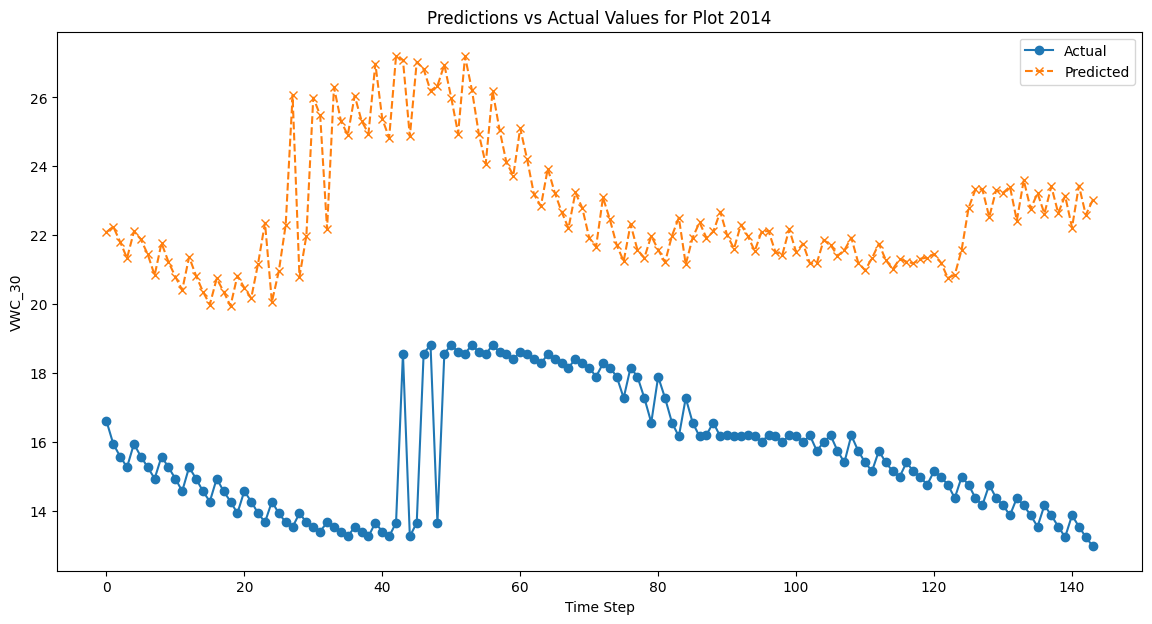

[[22.08496094 22.24805832 21.80490875 21.33270264]
 [22.10652542 21.88152885 21.44303703 20.83548927]
 [21.76967049 21.22710419 20.79512024 20.40690994]
 [21.36739349 20.82218933 20.36248016 19.98154831]
 [20.74113083 20.3605957  19.94605064 20.82019043]
 [20.47241592 20.17077255 21.17541885 22.35751724]
 [20.05993462 20.94817162 22.29703522 26.05750275]
 [20.78567314 21.98446465 25.99494553 25.48222542]
 [22.17860794 26.29837608 25.32422638 24.90274048]
 [26.04977798 25.32123947 24.94948196 26.97940636]
 [25.37747383 24.82907486 27.19670486 27.08712196]
 [24.86709595 27.03236771 26.81977463 26.19542122]
 [26.33666992 26.94946671 25.9923954  24.94668388]
 [27.19189072 26.21473122 24.94213867 24.07011032]
 [26.18829346 25.06556511 24.11353683 23.73216057]
 [25.10672188 24.20692444 23.18084335 22.84452248]
 [23.93580818 23.2383461  22.6796875  22.20007706]
 [23.24003029 22.78906059 21.92562294 21.66388512]
 [23.09462738 22.45521927 21.70538521 21.24260712]
 [22.31517792 21.57002258 21.34

In [6]:
# Example usage
plot_numbers = [2013]  # Example plot numbers for training
target_column = "VWC_30"
continuous_columns = [
    "Ta_2m_Avg", "RH_2m_Avg", "Solar_2m_Avg", "WndAveSpd_3m", "Rain_1m_Tot",
    "Dp_2m_Avg", "TaMax_2m", "TaMin_2m", "RHMax_2m", "RHMin_2m",
    "HeatIndex_2m_Avg", "irrigation", "precip_irrig", "canopy_temp"
]

model_save_path = os.path.join(os.getcwd(), "models") 

print(model_save_path)
forecast_horizon = 4

# Train models
prepare_and_train_models(plot_numbers, target_column, continuous_columns, forecast_horizon, model_save_path)

# Inference
plot_number_for_inference = 2014  # Example plot number for inference
predictions = run_inference(model_save_path, plot_number_for_inference, target_column, continuous_columns, forecast_horizon)
print(predictions)